## Data from sediment 
As in previous approaches we didnt reach any good results for niether 3 nor 5 classes classification. In this notebook we will focus on 1 vs many classification to explore classes and find out if we can divide dataset more succesfully.  

In [2]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# for tensorboard logs
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, SMOTEN

np.random.seed(111)
tf.random.set_seed(111)


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Data/sed_bacteria_merged.csv')
predictors = df.columns[1:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")
      
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"class_timepoint",  classes)

# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()




number of predictors/bacteria famillies: 227


,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# for normalisation we will use starndard min-max normalisation
df[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,0.238804,0.345469,0.125680,0.353059,0.127573,0.167674,0.156283,0.142692,0.223499,...,0.033846,0.022500,0.020000,0.020000,0.030000,0.020000,0.020000,0.020000,0.020000,0.020000
std,0.505076,0.196842,0.256620,0.189293,0.236595,0.211493,0.248427,0.220008,0.221357,0.276172,...,0.170354,0.142163,0.141421,0.141421,0.156818,0.141421,0.141421,0.141421,0.141421,0.141421
min,0.000000,0.000000,0.011719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.086957,0.134766,0.012645,0.195588,0.000000,0.000000,0.000000,0.000000,0.007019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.222826,0.287109,0.046628,0.332353,0.038835,0.023256,0.053097,0.028846,0.110151,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.343071,0.472656,0.156481,0.470588,0.189320,0.255814,0.247788,0.192308,0.424946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In this approach we will use 3 class classification based only on water supplementation 
Those classes will be: No supplementation, Em farma, EM

| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [68]:
# Decoding 

codes5 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

codes3 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32], 2 : [9,13,17,20,27,11,15,22,25,31]}
codes2 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32, 9,13,17,20,27,11,15,22,25,31]}
df['pond_org'] = df['pond']
df['pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes2))

C:\Users\marek\AppData\Local\Temp\ipykernel_8764\3284167141.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['pond_org'] = df['pond']


In [69]:
pondXtime = df['pond'].astype(str) + "_" + df['class_timepoint'].astype(str)
df.insert(1,"pondXtime", pondXtime)

C:\Users\marek\AppData\Local\Temp\ipykernel_8764\1706034138.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1,"pondXtime", pondXtime)


In [70]:
df.head()
df['pondXtime'].value_counts()

pondXtime
1_0    20
1_1    20
0_0     5
0_1     5
Name: count, dtype: int64

As the splitting dataset into train/val and test didnt workout due to probably small number of samples we will stick to only train/val datasets

In [71]:
train_val_df = df.copy()
del(df)

In [72]:
train_val_df['pond'].value_counts()

pond
1    40
0    10
Name: count, dtype: int64

In [73]:
#train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
#print(train_val_df.shape, test_df.shape)

### Definitions

For crossvalidation purposes we will create 5 subsets of size 10 each, 4 of them will be used as train dataset and one as validating dataset.  This then will be repeated 4 times and validation result will be mean of results.

In [74]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [75]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=1000,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

## Modelling 
We will perform 1 vs many classificaiton, There will be big overepresentation of many and we can expect the model to just classify everything to class "many" as this will give the best results on paper. Most biological sense makes to try controll vs many so thats where we will start thats why we will not test that extensively. 

### Modelling controll vs rest

In [15]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dense(16, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(2, activation ='softmax'))

print(model1.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,786 (151.51 KB)

 Trainable params: 38,786 (151.51 KB)

 Non-trainable params: 0 (0.00 B)

None


training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6000 - loss: 3.3218
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
predicted classes:       [1 1 1 1 1 1 1 1 1 1]
true validation classes: [1 0 0 0 1 1 1 1 1 0]
mean confidence score: 105840.4359, sd confidence score: 182765.1951
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6000 - loss: 2.8939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [0 1 1 1 0 1 1 1 1 1]
true validation classes: [1 1 0 1 1 1 1 0 1 1]
mean confidence score: 2503611.6884, sd confidence score: 7141451.2699
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.4682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [1 1 1 0 1 1 1 1 1 1]
true validation classes: [1 1 0 1 1 1 1 1 1 1]
mean confidence score: 9030267.4436, sd confidence score: 27040503.7285
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 1.8279
1/1 ━━━━━━━━━━━

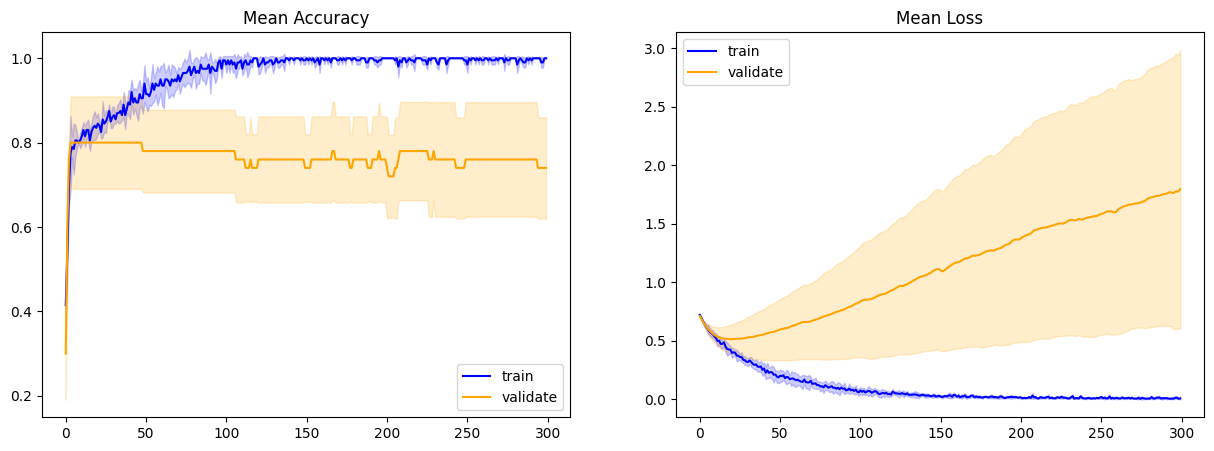

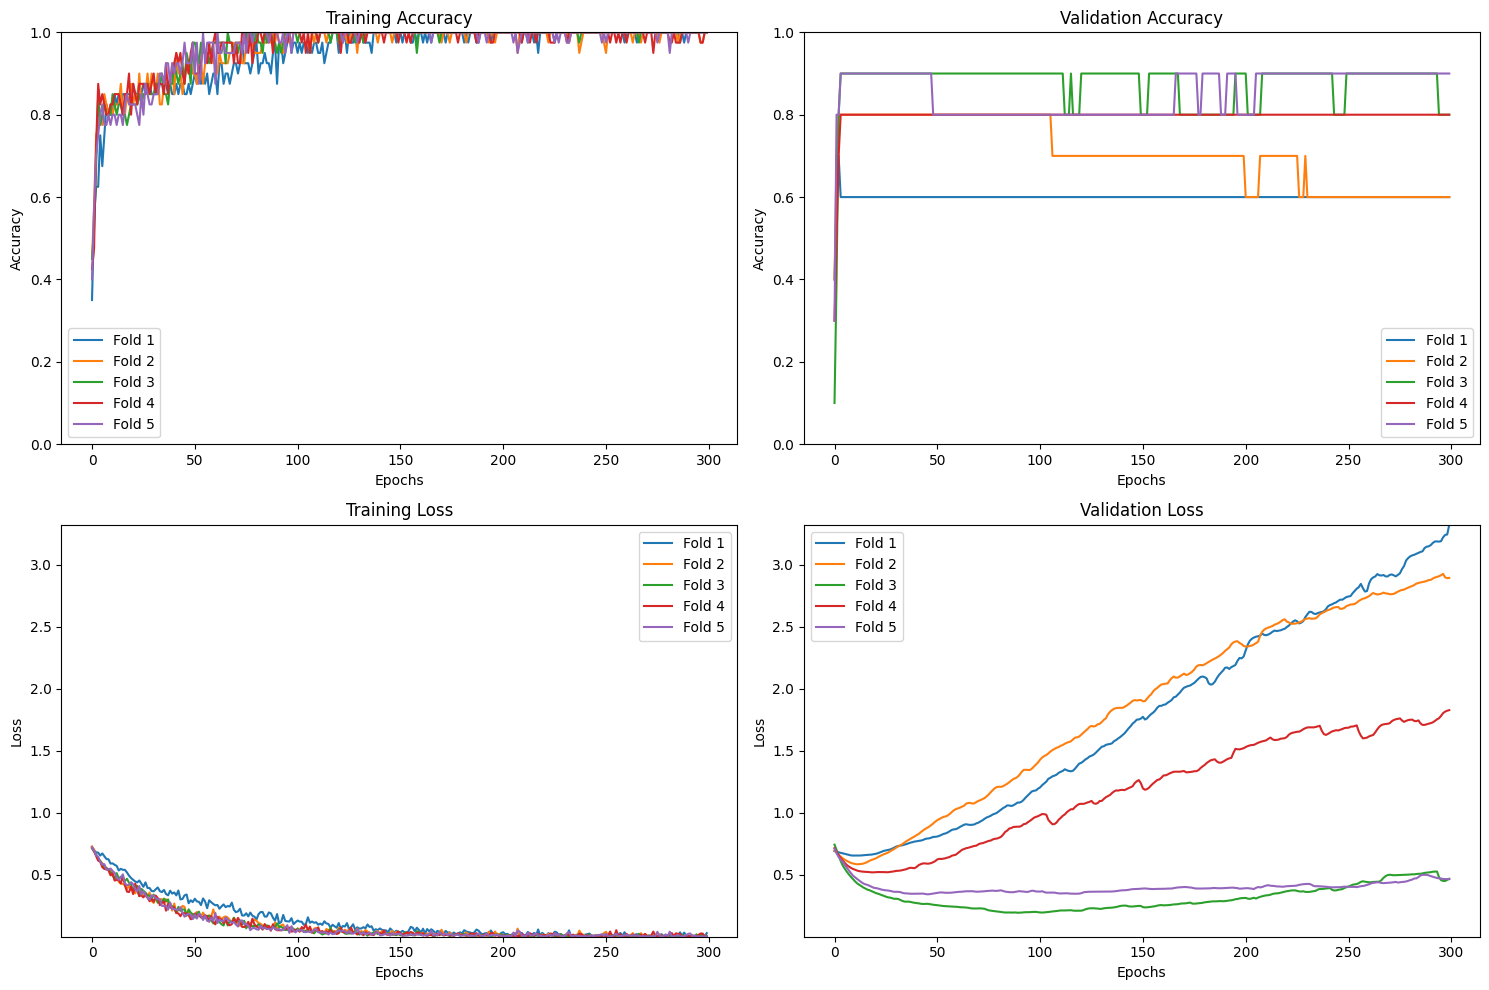

In [16]:
crossvalidate(train_val_df, model1, predictors, 'pond', kf)

As we suspected because of overrepresentaion model is classifying everything to class 1 (many), and is pretty sure of its decisions with very high confidence sscore. We can fight this by oversampling our controll class.

### Oversampling controll
ref: 
Learning from Imbalanced Data
Haibo He, Member, IEEE, and Edwardo A. Garcia 
https://sci-hub.st/10.1109/tkde.2008.239
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

For oversampling we will use SMOTE algorythm as it is more sophisticated than just duplicating.

In [18]:
smote = SMOTE(random_state=111)
X = train_val_df[predictors].values
y = train_val_df['pond']
X_smote, y_smote = smote.fit_resample(X, y)
 

In [19]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

(50, 227) (50,)
(80, 227) (80,)


In [20]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)


#### Modeling oversampled dataset

In [22]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,514 (150.45 KB)

 Trainable params: 38,514 (150.45 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9375 - loss: 0.0877
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
predicted classes:       [1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
true validation classes: [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
mean confidence score: 42.783, sd confidence score: 27.8328
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9375 - loss: 0.2319
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
true validation classes: [1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 40.9887, sd confidence score: 25.8726
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9375 - loss: 0.3192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
predicted classes:       [0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0]
true validation classes: [0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 58.1371, sd confidence score: 41.5307
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accura

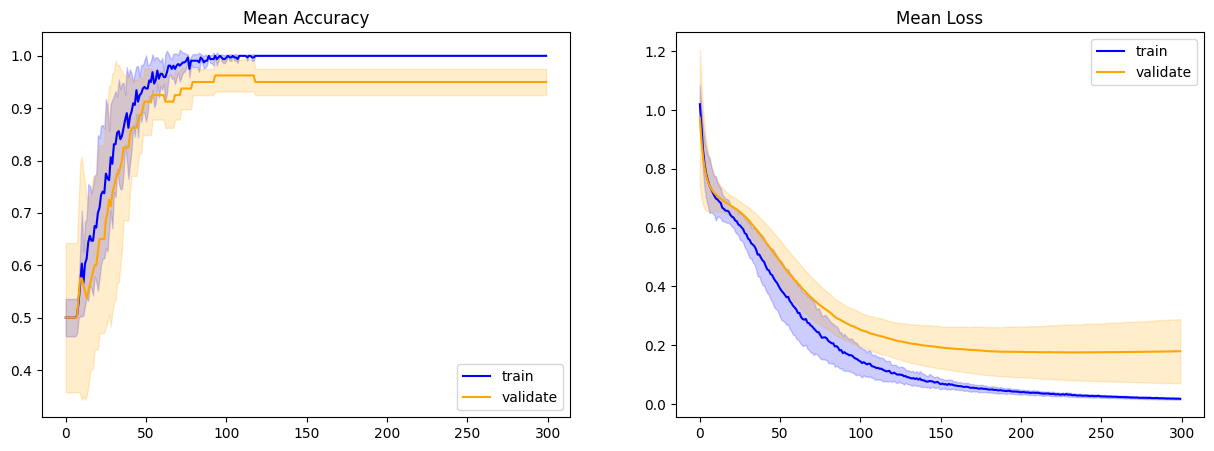

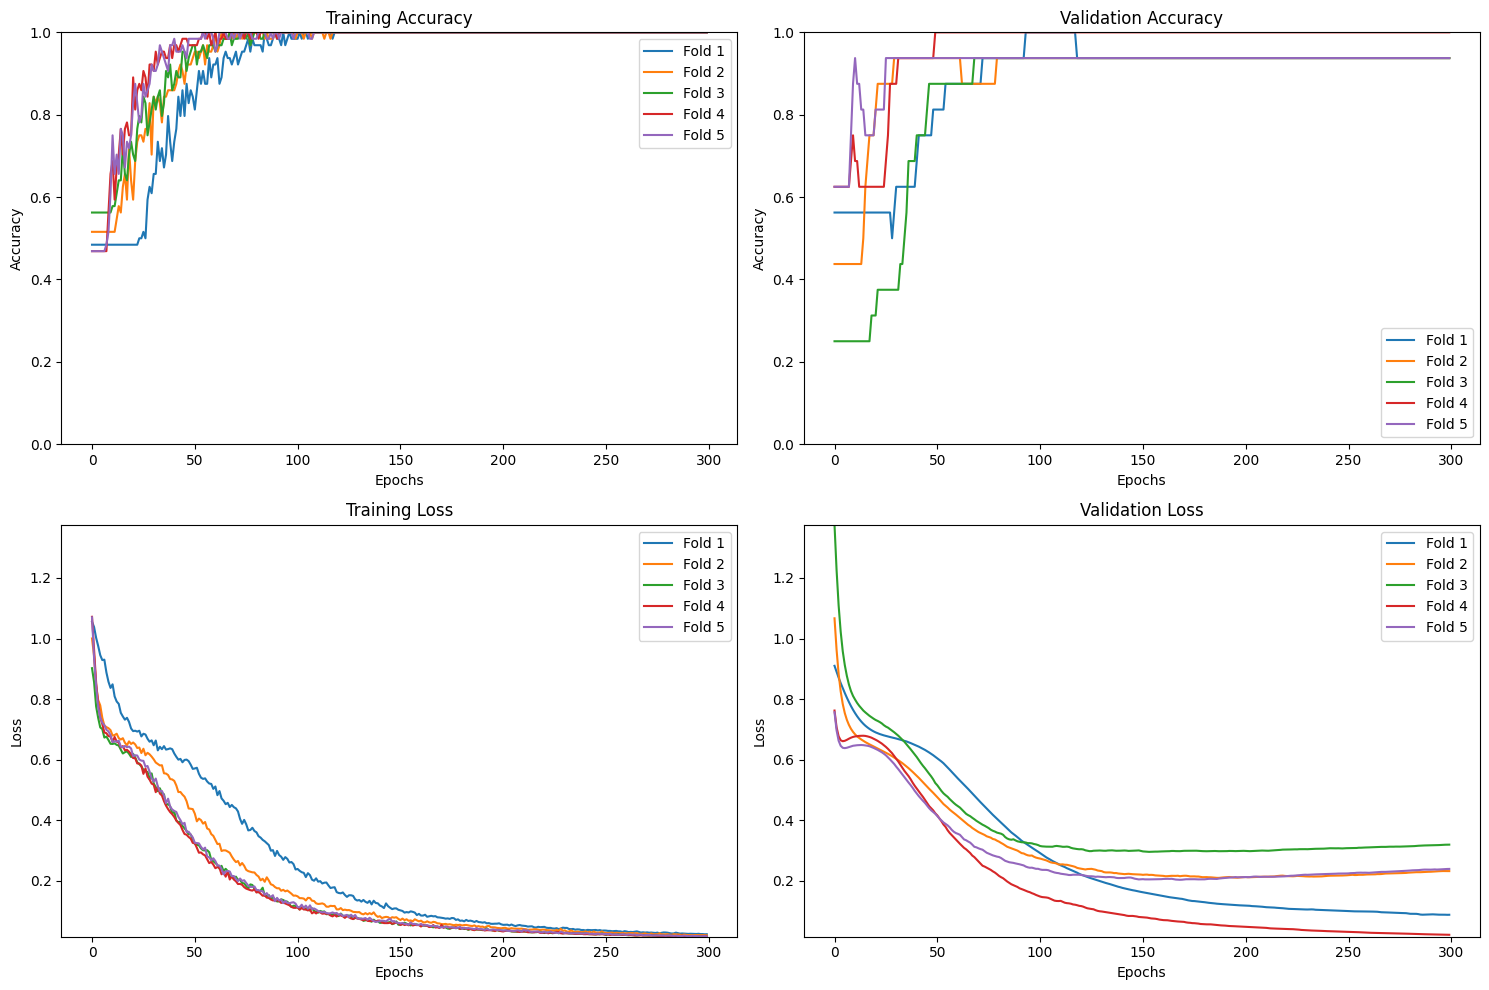

In [23]:
crossvalidate(df_smote, model2, predictors, 'pond', kf)

We can note that results skyrocketed to nearly perfect accuracy from this time baseline of 0.5, also loss curves indicate that there is no overfitting during whole 300 epoch training and we have very well trained model. Possible causes for that are: ideally there are significant enough differences between controll and rest of setups and we no longer have overrepresentation problem. This would make most biological sense. There might be another cause that the model is somehow classifying not controll vs rest but its rather detecting SMOTE generated samples and classyfing based on that. We could check that using less sophisticated oversampling method like sample dupplication.

### Oversampling by dupplication 
Here we will check whenever model is detecting samples generated with SMOTE, we will do that by using sample dupplication instead of smote but because we are dupplicating by a factor of 4, there might be no practical difference between controll train and test samples, to avoid that we will controll how we assign samples before dupplicating.

In [64]:
X =  train_val_df[predictors].values
y = train_val_df['pond'].values
#y = keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, random_state=2)


In [65]:
# oversampling by dupplication of minority class
train_df = pd.concat([pd.DataFrame(X_train, columns=predictors), pd.DataFrame(y_train, columns=['pond'])], axis=1)
class_0_samples = train_df[train_df['pond'] == 0]
oversampled_class_0_samples = pd.concat([class_0_samples] * 5, ignore_index=True)
oversampled_train_data = pd.concat([train_df, oversampled_class_0_samples], ignore_index=True)



In [66]:
X_train_oversampled = oversampled_train_data[predictors].values
y_train_oversampled = oversampled_train_data['pond'].values

In [67]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='sigmoid'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='sigmoid'))

model3.add(keras.layers.Dense(2, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
history3 = model3.fit(X_train_oversampled, keras.utils.to_categorical(y_train_oversampled), epochs=300, batch_size=5, validation_data=(X_test, keras.utils.to_categorical(y_test)), verbose=0)

In [69]:
y_pred = model3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)
print(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[1 1 1 1 1 1 1 1 1 1]
[1 0 0 0 1 1 1 0 0 1]


We can see that the model is back to predicting everything as class 1 and overrperesentation should not be a problem , issue with this approach is that we have only 5 original samples from control in our training dataset and this might just not be enough for proper learning. For now we will trust that model is not just detecting SMOTE ggenerated samples and that it is actually detecting differences between controll and the rest. Now with that out of the way lets move to the next step.

### (from 5 class)  class 1 vs rest both timepoints
We will now conitinue our class exploration by trying to model for both timepoints for class 1 vs rest.

In [81]:

codes5 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}


codes2 = {0 :[12,16,19,23,26], 1: [8,14,18,24,29, 10,21,28,30,32 ,9,13,17,20,27 ,11,15,22,25,31]}

df['pond'] = df['pond_org'].apply(lambda x: pond_decoder(x,codes2))

In [82]:
smote = SMOTE(random_state=111)
X = train_val_df[predictors].values
y = train_val_df['pond']
X_smote, y_smote = smote.fit_resample(X, y)

df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)

print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)


(50, 227) (50,)
(80, 227) (80,)


In [84]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='sigmoid'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='sigmoid'))

model4.add(keras.layers.Dense(2, activation ='softmax'))

model4.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,514 (150.45 KB)

 Trainable params: 38,514 (150.45 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0604
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
predicted classes:       [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
true validation classes: [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
mean confidence score: 60.8112, sd confidence score: 34.497
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9375 - loss: 0.2326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
true validation classes: [1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 82.9684, sd confidence score: 40.6278
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9375 - loss: 0.3065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0]
true validation classes: [0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 98.1718, sd confidence score: 35.0318
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accura

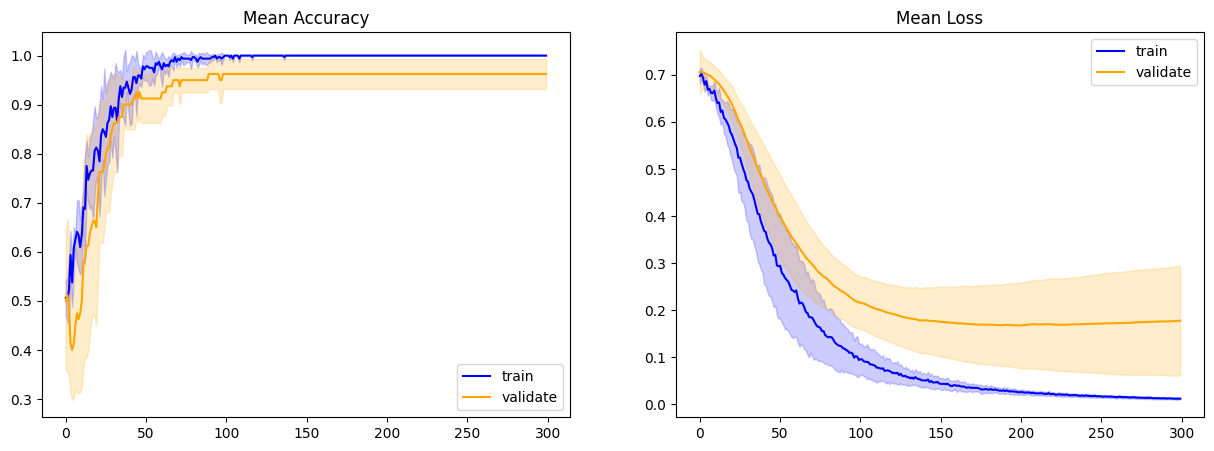

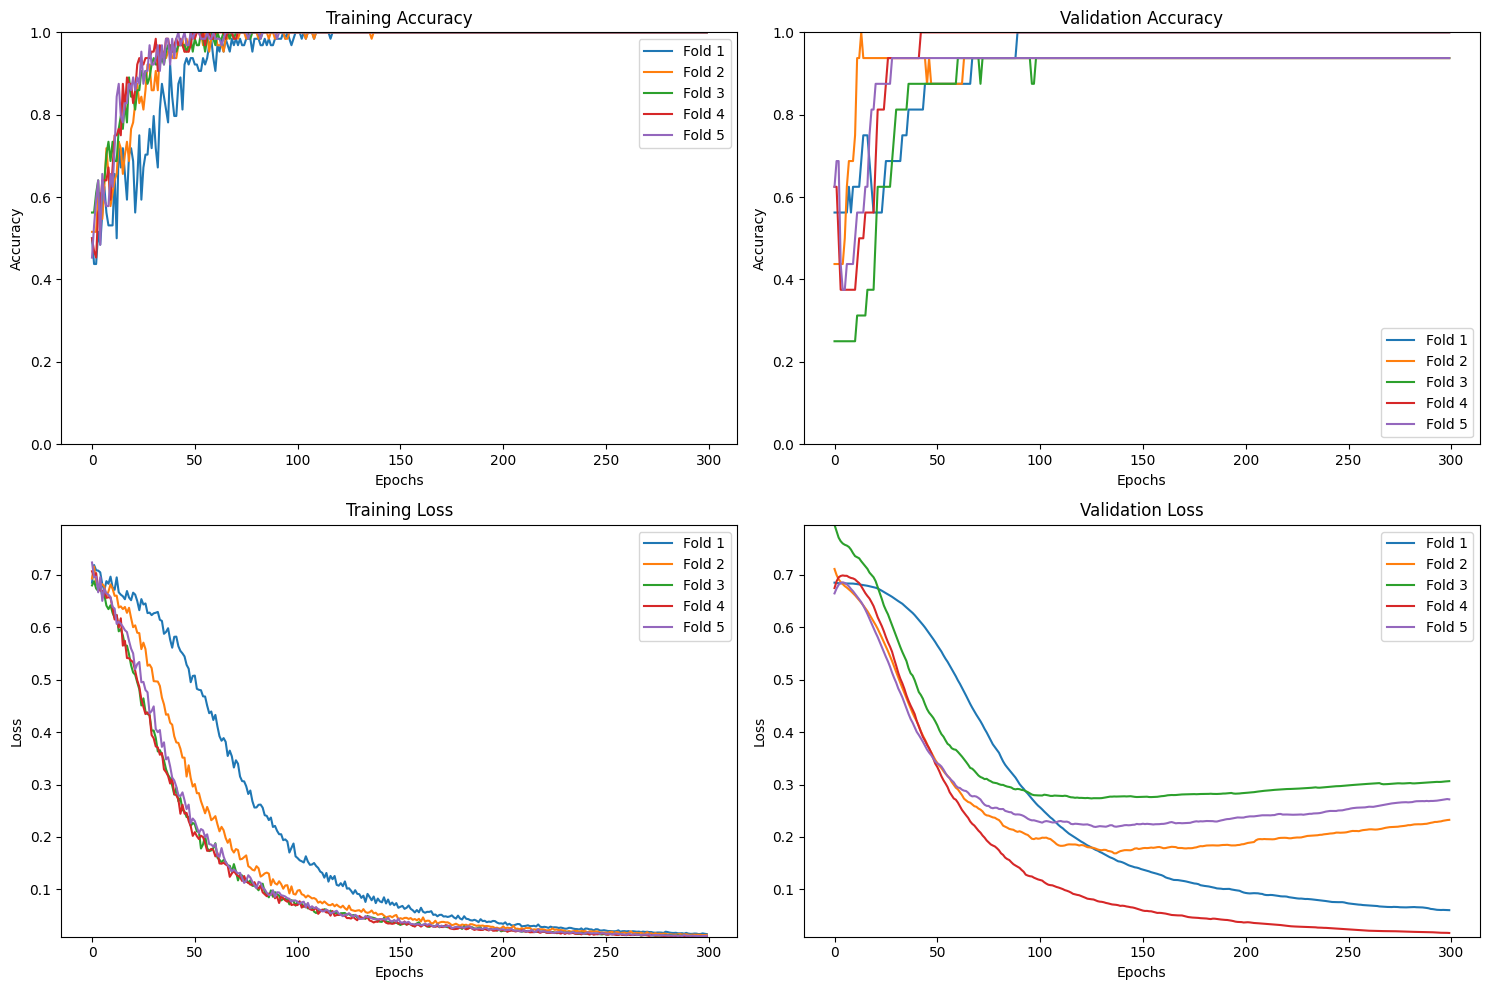

In [85]:
crossvalidate(df_smote, model4, predictors, 'pond', kf)

Once again we can see near perfect accuracy which suggest differences, Lets do that for the rest of the classes before drawing conclusions.

### (from 5 class)  class 2 vs rest both timepoints
We will now conitinue our class exploration by trying to model for both timepoints for class 1 vs rest.a

(50, 227) (50,)
(80, 227) (80,)


C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,514 (150.45 KB)

 Trainable params: 38,514 (150.45 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0626
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
predicted classes:       [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
true validation classes: [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
mean confidence score: 49.2695, sd confidence score: 23.3554
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9375 - loss: 0.2300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicted classes:       [0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
true validation classes: [1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 57.0153, sd confidence score: 21.901
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9375 - loss: 0.2806
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0]
true validation classes: [0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 71.6233, sd confidence score: 21.1383
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accura

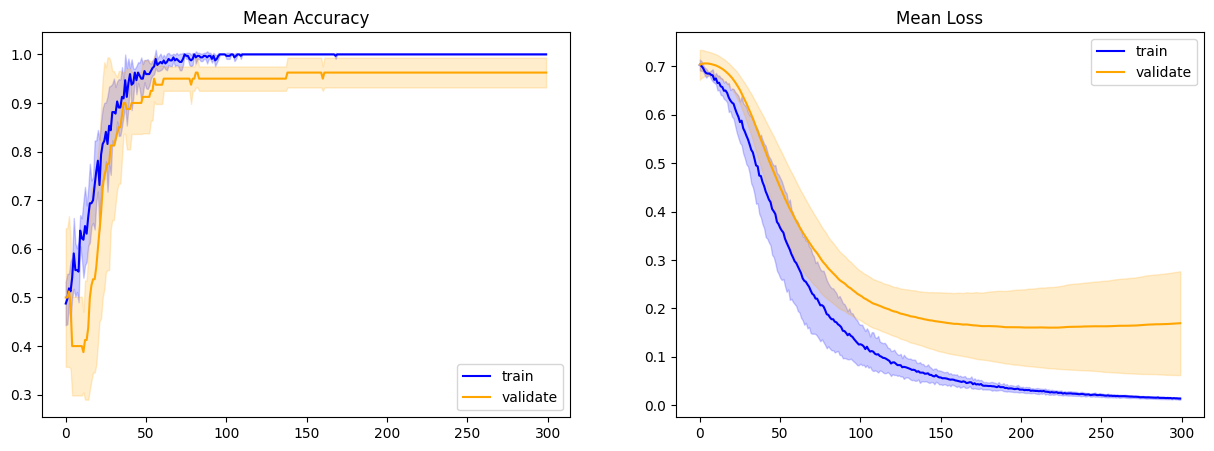

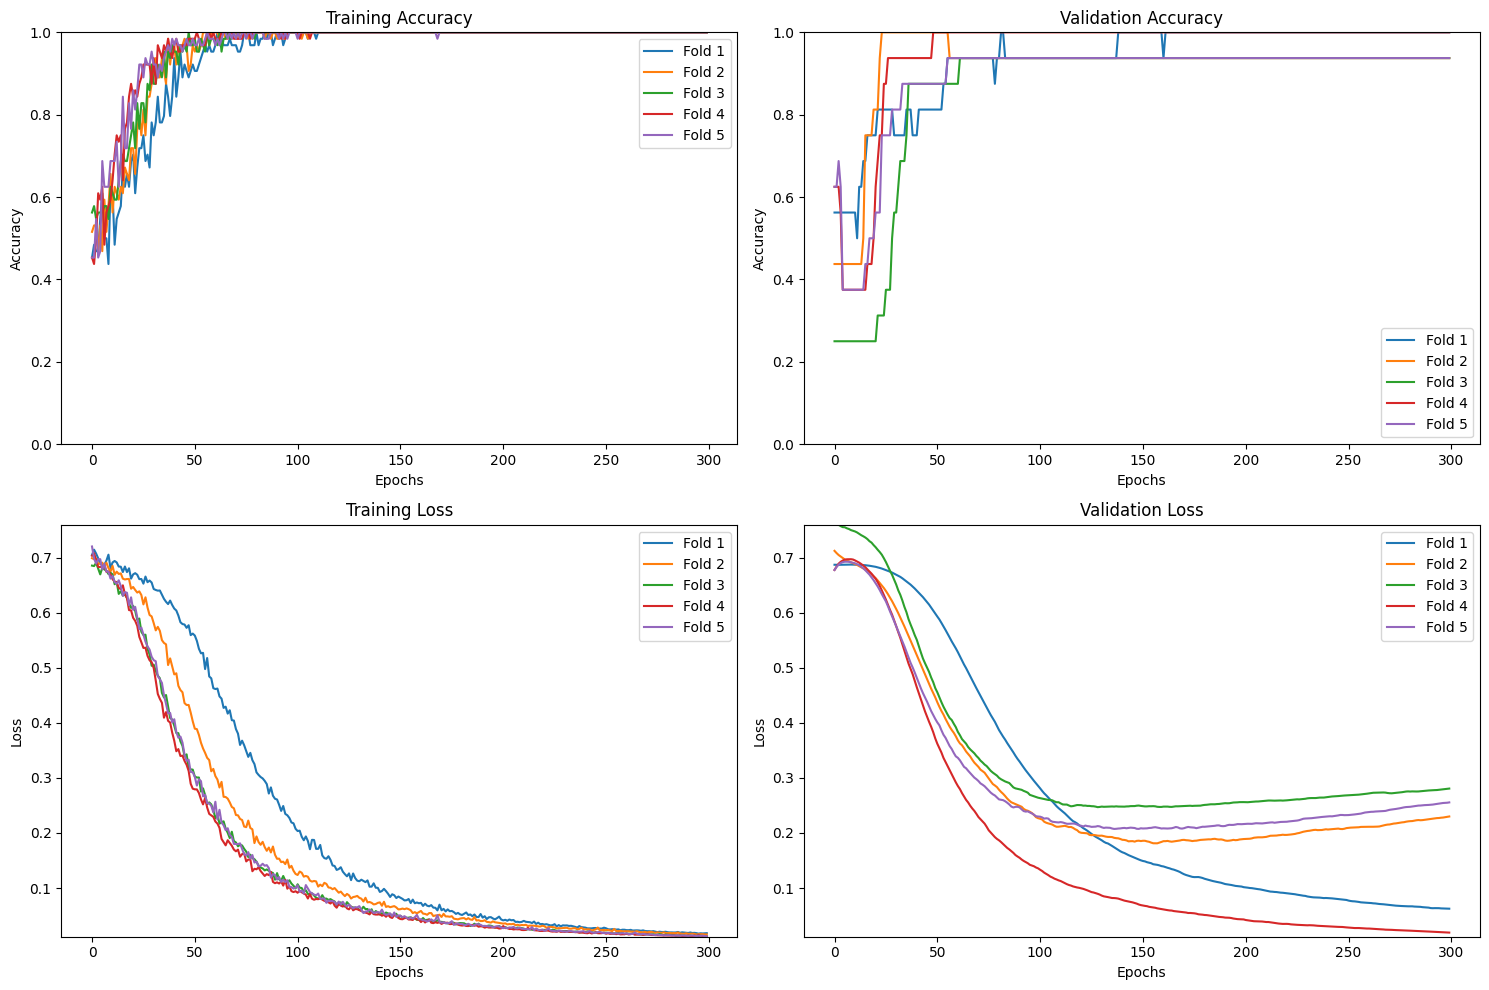

In [87]:


codes5 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}


combined_elements = codes5[0] + codes5[1] + codes5[3] + codes5[4]

# Create the new dictionary
codes2 = {
    0: codes5[2],  # Elements of key 2 assigned to key 0
    1: combined_elements  # Combined elements assigned to key 1
}

df['pond'] = df['pond_org'].apply(lambda x: pond_decoder(x,codes2))
smote = SMOTE(random_state=111)
X = train_val_df[predictors].values
y = train_val_df['pond']
X_smote, y_smote = smote.fit_resample(X, y)

df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)

print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

model4 = keras.Sequential()



model4.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='sigmoid'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='sigmoid'))

model4.add(keras.layers.Dense(2, activation ='softmax'))

model4.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)
crossvalidate(df_smote, model4, predictors, 'pond', kf)

### (from 5 class)  class 3 vs rest both timepoints
We will now conitinue our class exploration by trying to model for both timepoints for class 1 vs rest.a

(50, 227) (50,)
(80, 227) (80,)


C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,514 (150.45 KB)

 Trainable params: 38,514 (150.45 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predicted classes:       [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
true validation classes: [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
mean confidence score: 62.3163, sd confidence score: 57.3393
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9375 - loss: 0.2389
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
true validation classes: [1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 114.8455, sd confidence score: 80.3045
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9375 - loss: 0.2515
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0]
true validation classes: [0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 111.3927, sd confidence score: 60.5891
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc

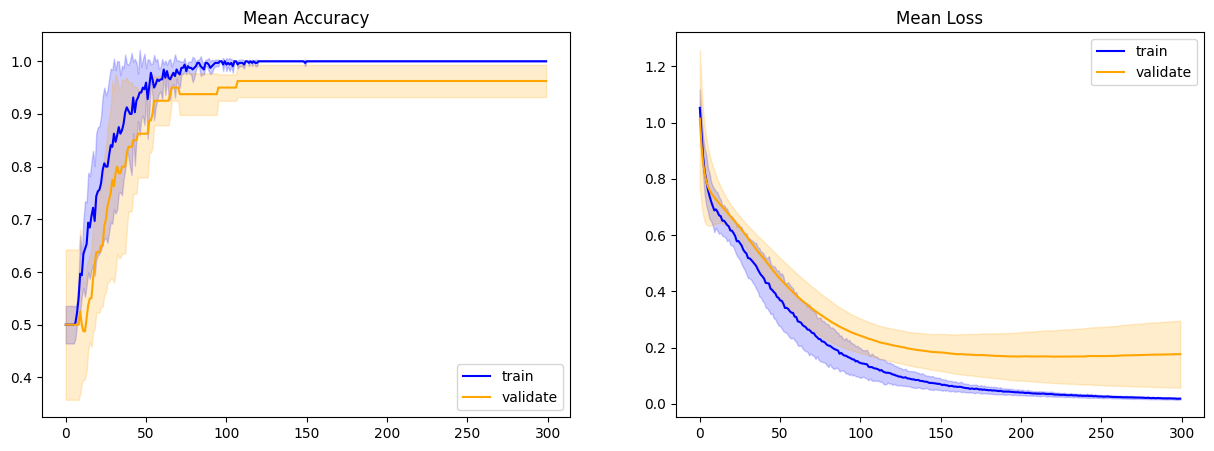

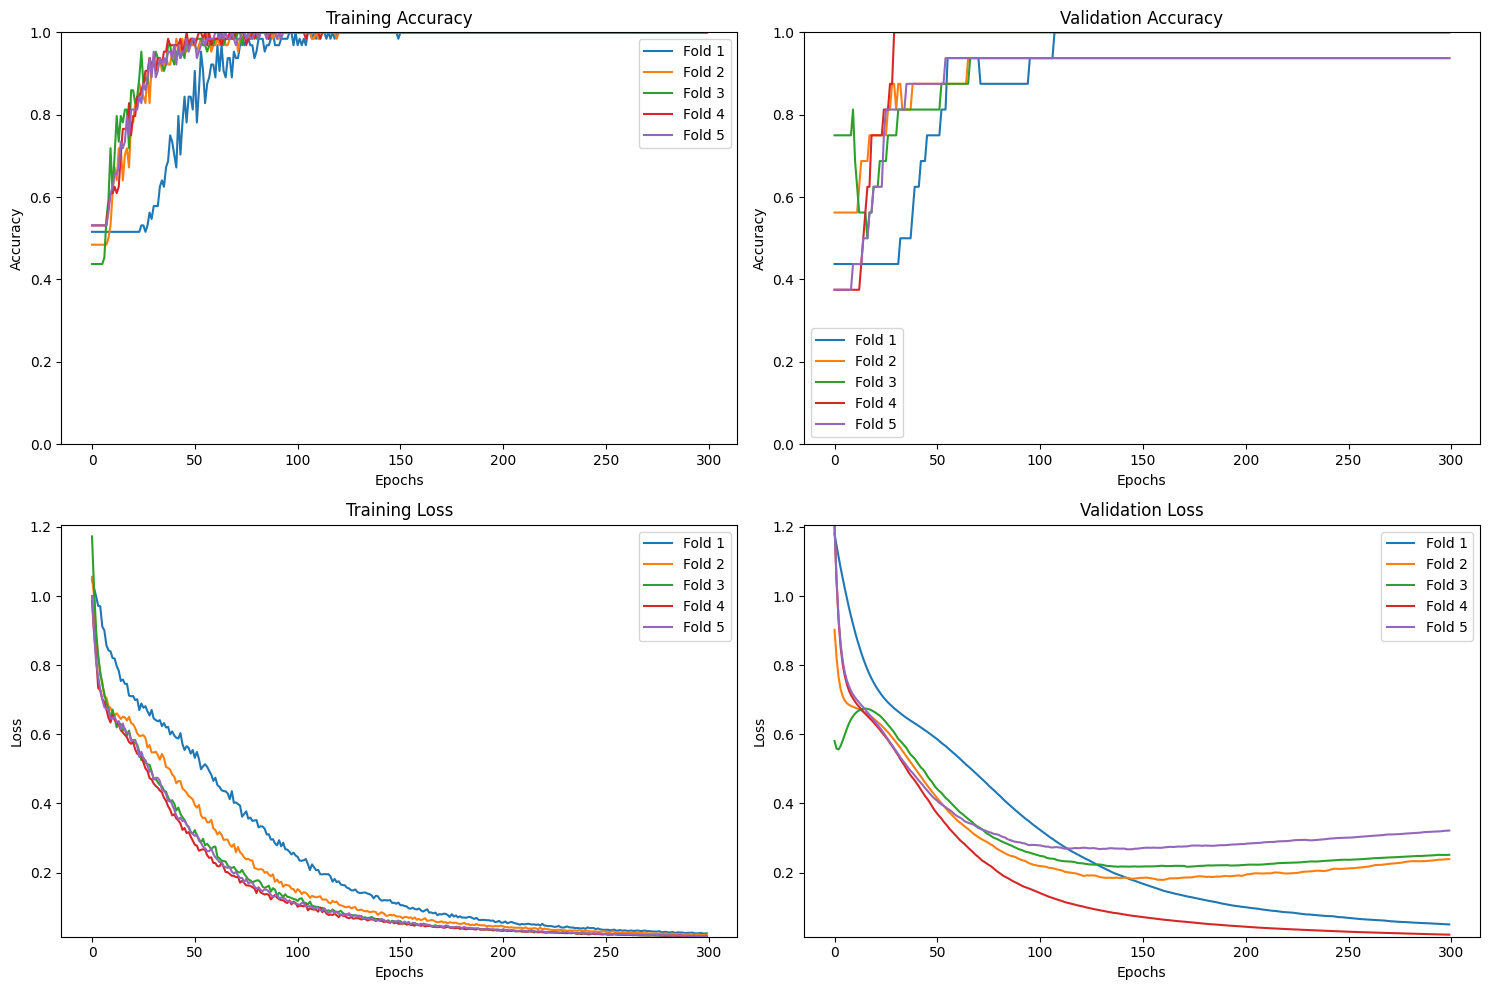

In [88]:


codes5 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}


combined_elements = codes5[0] + codes5[1] + codes5[2] + codes5[4]

# Create the new dictionary
codes2 = {
    0: codes5[3],  # Elements of key 2 assigned to key 0
    1: combined_elements  # Combined elements assigned to key 1
}

df['pond'] = df['pond_org'].apply(lambda x: pond_decoder(x,codes2))
smote = SMOTE(random_state=111)
X = train_val_df[predictors].values
y = train_val_df['pond']
X_smote, y_smote = smote.fit_resample(X, y)

df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)

print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

model4 = keras.Sequential()



model4.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='sigmoid'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='sigmoid'))

model4.add(keras.layers.Dense(2, activation ='softmax'))

model4.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)
crossvalidate(df_smote, model4, predictors, 'pond', kf)

### (from 5 class)  class 4 vs rest both timepoints
We will now conitinue our class exploration by trying to model for both timepoints for class 1 vs rest.a

(50, 227) (50,)
(80, 227) (80,)


C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,514 (150.45 KB)

 Trainable params: 38,514 (150.45 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
predicted classes:       [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
true validation classes: [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
mean confidence score: 55.1201, sd confidence score: 31.9016
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9375 - loss: 0.2191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted classes:       [0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
true validation classes: [1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 72.7823, sd confidence score: 38.5193
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9375 - loss: 0.2885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0]
true validation classes: [0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 83.9182, sd confidence score: 25.2697
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accur

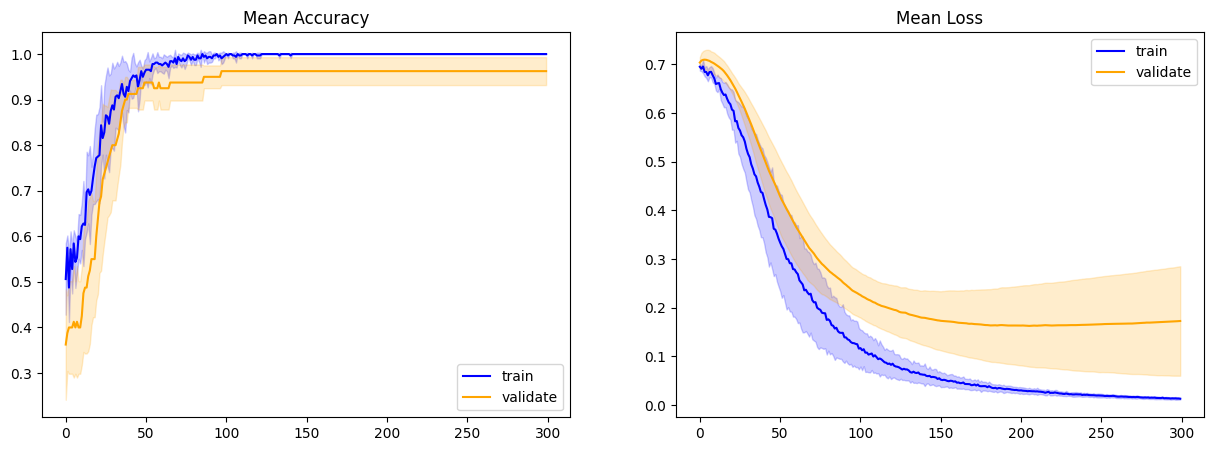

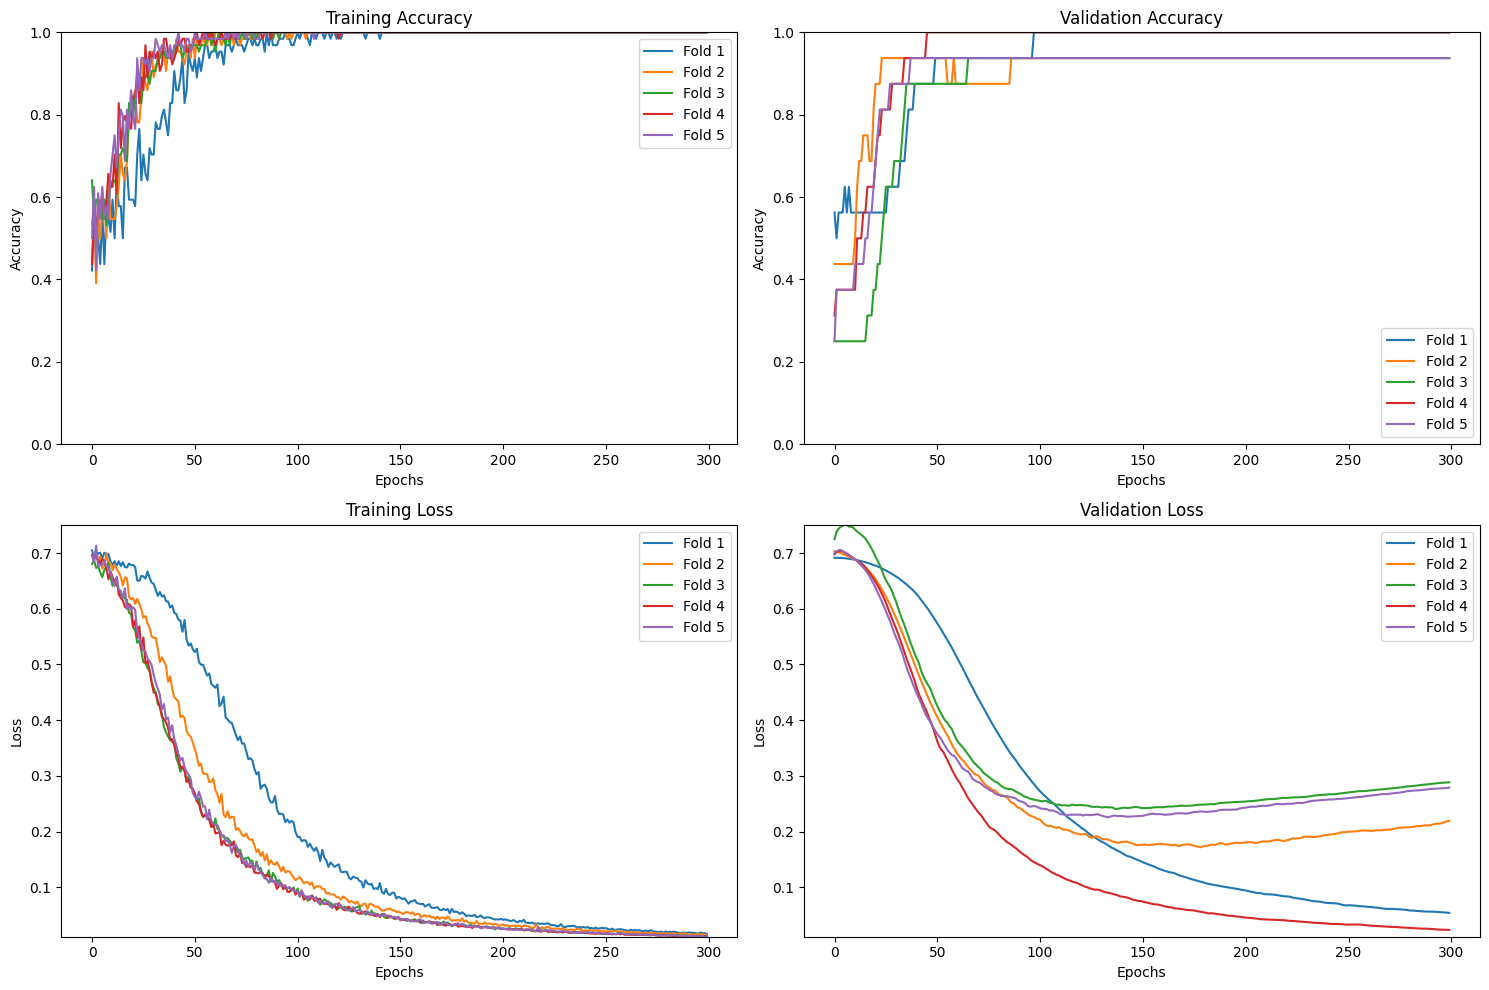

In [89]:


codes5 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}


combined_elements = codes5[0] + codes5[1] + codes5[2] + codes5[3]

# Create the new dictionary
codes2 = {
    0: codes5[4],  # Elements of key 2 assigned to key 0
    1: combined_elements  # Combined elements assigned to key 1
}

df['pond'] = df['pond_org'].apply(lambda x: pond_decoder(x,codes2))
smote = SMOTE(random_state=111)
X = train_val_df[predictors].values
y = train_val_df['pond']
X_smote, y_smote = smote.fit_resample(X, y)

df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)

print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

model4 = keras.Sequential()



model4.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='sigmoid'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='sigmoid'))

model4.add(keras.layers.Dense(2, activation ='softmax'))

model4.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)
crossvalidate(df_smote, model4, predictors, 'pond', kf)

## Conclusions from 1 vs many 
So results for each class are nearly perfect that is suprising as that means that networks is capable of recognising differences between each class and rest of them, then question is why our initial 5 class classification for both timepoints went extremely porrly, Possible cause for that may be lack of samples we might try to oversample all of samples using SMOTE algorythm and using this we will also check if network is recognising SMOTE generated samples.

In [157]:
codes5 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}
combined_elements = codes5[0] + codes5[1] + codes5[2] + codes5[3]
train_val_df['pond'] = train_val_df['pond_org'].apply(lambda x: pond_decoder(x,codes5))

In [158]:
train_df, test_df = train_test_split(train_val_df, test_size=10, random_state=111, stratify=train_val_df['pond'])

In [159]:
train_df.shape, test_df.shape

((40, 231), (10, 231))

In [160]:
empty_class = pd.DataFrame(0, index=range(40),columns=train_df.columns)
#empty_class[] = np.random.rand(40, empty_class.shape[1])
empty_class['pond'] = 9


In [163]:
train_val_df_empty_class = pd.concat([train_df, empty_class], axis=0)

In [164]:
train_val_df_empty_class

,pond,pondXtime,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,pond_org
41,2,1_1,1,1.000000,0.578125,1.000000,0.376471,0.000000,0.709302,0.035398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sed_S30
45,2,1_1,1,0.078804,0.269531,0.019494,0.229412,0.300971,0.000000,0.123894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sed_S32
3,4,1_1,1,0.008152,0.050781,0.009484,0.017647,0.000000,0.034884,0.159292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sed_S11
40,2,1_0,0,0.508152,0.472656,0.042150,0.452941,0.000000,0.720930,0.053097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sed_S30
10,4,1_0,0,0.445652,0.390625,0.200738,0.194118,0.000000,0.569767,0.008850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sed_S15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,9,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
36,9,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
37,9,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38,9,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [165]:
smote = SMOTE(random_state=111)
X = train_val_df_empty_class[predictors].values
y = train_val_df_empty_class['pond']

In [166]:
y.value_counts()

pond
9    40
2     8
4     8
1     8
3     8
0     8
Name: count, dtype: int64

In [167]:
X.shape, y.shape

((80, 227), (80,))

In [168]:
X_smote, y_smote = smote.fit_resample(X, y)
y_smote.shape

(240,)

In [169]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)
df_smote_cleared = df_smote[df_smote['pond'] != 9]
df_smote_cleared.reset_index(drop=True, inplace=True)
print(df_smote_cleared.shape)
df_smote_cleared['pond'].value_counts()

(200, 228)


pond
2    40
4    40
1    40
3    40
0    40
Name: count, dtype: int64

(80, 227) (80,)
(240, 227) (240,)
training for 1 subset


C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0436  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predicted classes:       [2 4 4 4 0 1 1 3 1 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4
 4 4 4]
true validation classes: [2 4 4 4 0 1 1 3 1 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4
 4 4 4]
mean confidence score: 93.3293, sd confidence score: 16.8874
training for 2 subset
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0360 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
predicted classes:       [4 2 3 4 1 0 1 3 1 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4
 4 4 4]
true validation classes: [4 2 3 4 1 0 1 3 1 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4
 4 4 4]
mean confidence score: 121.7423, sd confidence score: 36.5882
training for 3 subset
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0297 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
predicted classes:       [2 2 2 4 1 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 

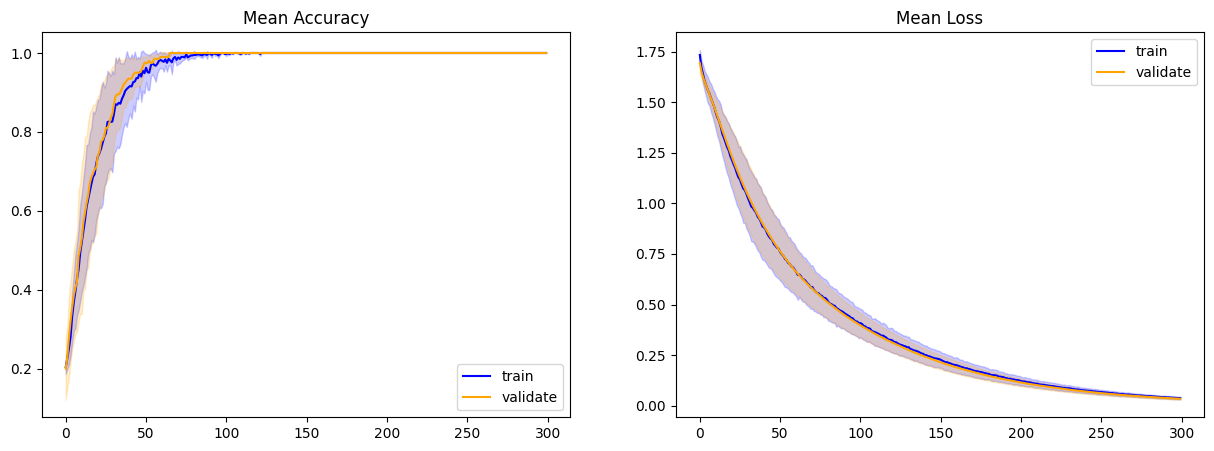

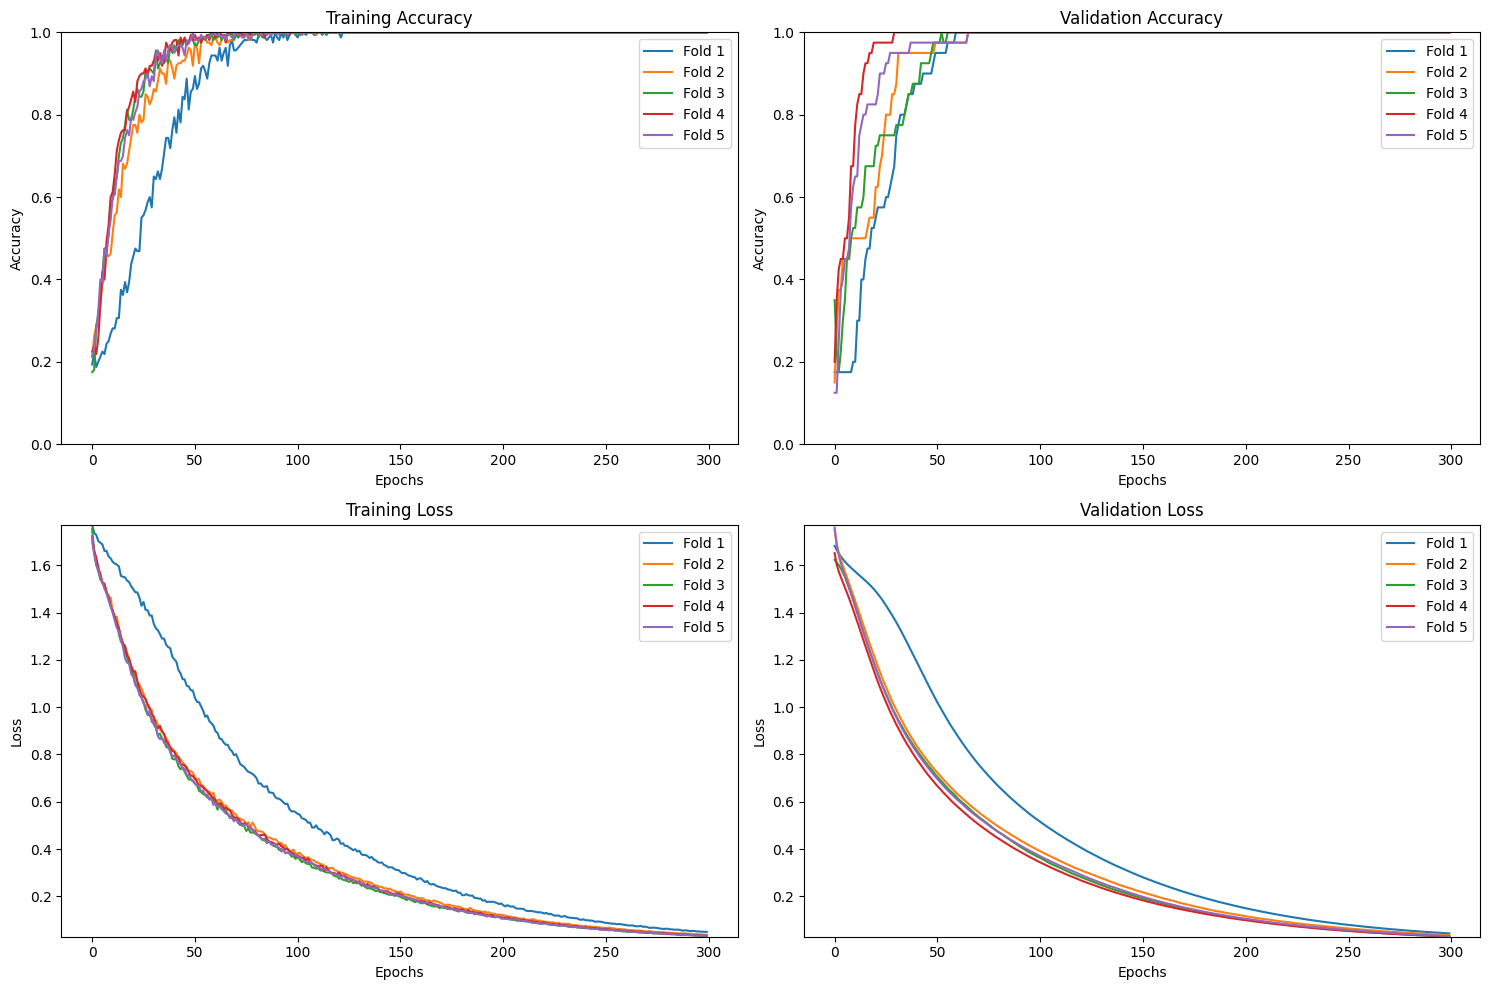

In [170]:


print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

model5 = keras.Sequential()
model5.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))
model5.add(keras.layers.Dropout(rate=0.25))
model5.add(keras.layers.Dense(64, activation ='sigmoid'))
model5.add(keras.layers.Dropout(rate=0.25))
model5.add(keras.layers.Dense(16, activation ='sigmoid'))
model5.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model5.compile(optimizer = optimizer, loss = loss, metrics=metrics)
crossvalidate(df_smote_cleared, model5, predictors, 'pond', kf)

The results from smote apmplified 5 class classification are great almost too great, It can still be the case that SMOTE generated samples are very similar to original ones and thus why validation dataset for the model is basically same as training data thats why accuracy is so great. To avoid that we will split dataset into train, validation and test.

In [179]:
X = df_smote_cleared[predictors].values
y = keras.utils.to_categorical(df_smote_cleared['pond'].values)
y_test = keras.utils.to_categorical(test_df['pond'].values)
X_test = test_df[predictors].values
reset_weights(model5)   

history5 = model5.fit(X, y, epochs=300, batch_size=5,validation_data=(X_test, y_test), verbose=1, callbacks=[es_callback])

Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2203 - loss: 1.6870 - val_accuracy: 0.2000 - val_loss: 1.6680
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2444 - loss: 1.6144 - val_accuracy: 0.3000 - val_loss: 1.6352
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3414 - loss: 1.5725 - val_accuracy: 0.3000 - val_loss: 1.6197
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3761 - loss: 1.5451 - val_accuracy: 0.2000 - val_loss: 1.6101
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4192 - loss: 1.5132 - val_accuracy: 0.3000 - val_loss: 1.6035
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5494 - loss: 1.4842 - val_accuracy: 0.3000 - val_loss: 1.5982
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5833 - loss: 1.4371 - val_accuracy: 0.3000 - val_loss: 1.5928
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5939 - loss: 1.4139 - val_accuracy: 0.4000 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6000 - loss: 1.5473
[1.5472744703292847, 0.6000000238418579]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted values: [2 1 2 0 4 2 2 1 4 4]
True values: [3 1 4 0 3 2 2 1 0 4]


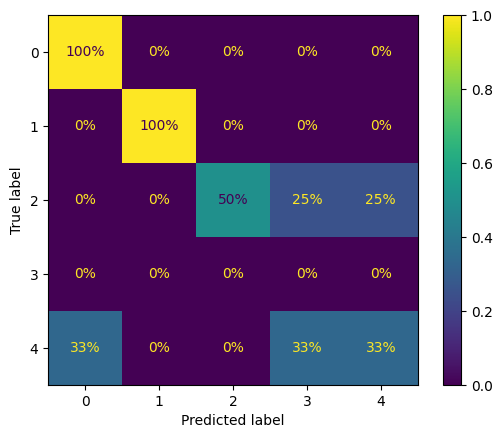

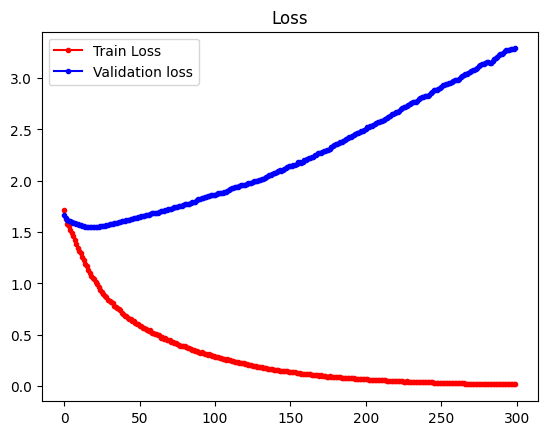

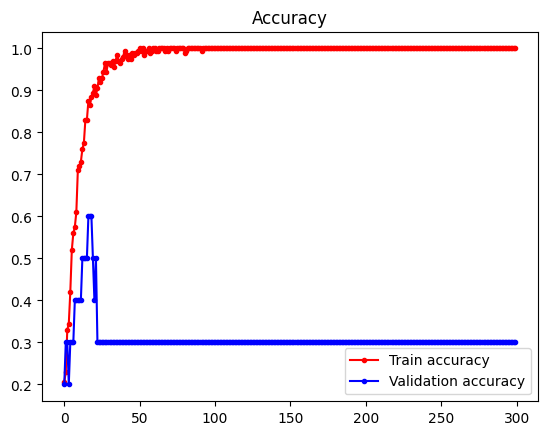

In [180]:

evaluate_model(model5, history5, X_test, y_test)


So we can see that our previous statement is most likely correct as the model have problem with classyfing samples from test dataset. Nevertheless results are much better than without any oversampling because here we peaked at accuracy of 0.6 in 18 epoch. The issue here is that we are using both timepoints at the same time (as one class) and there should be from biological perspective change in classes 1:4 form tp1 to tp2. In next notebook we will implement that using all observations from tp1 as controll and oversampled observations from tp2 class 1:4 as the rest of classes.